# Tutorial 30: Nested Clustered Optimization (NCO)

## 1. Downloading the data:

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import warnings

warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:.4%}'.format

# Date range
start = '2016-01-01'
end = '2019-12-30'

# Tickers of assets
assets = ['JCI', 'TGT', 'CMCSA', 'CPB', 'MO', 'APA', 'MMC', 'JPM',
          'ZION', 'PSA', 'BAX', 'BMY', 'LUV', 'PCAR', 'TXT', 'TMO',
          'DE', 'MSFT', 'HPQ', 'SEE', 'VZ', 'CNP', 'NI', 'T', 'BA']
assets.sort()

# Downloading data
data = yf.download(assets, start = start, end = end)
data = data.loc[:,('Adj Close', slice(None))]
data.columns = assets

[*********************100%%**********************]  25 of 25 completed


In [2]:
# Calculating returns

Y = data[assets].pct_change().dropna()

display(Y.head())

,APA,BA,BAX,BMY,CMCSA,CNP,CPB,DE,HPQ,JCI,...,NI,PCAR,PSA,SEE,T,TGT,TMO,TXT,VZ,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-05,-2.0257%,0.4057%,0.4035%,1.9693%,0.0180%,0.9305%,0.3678%,0.5783%,0.9482%,-1.1953%,...,1.5881%,0.0212%,2.8236%,0.9758%,0.6987%,1.7539%,-0.1730%,0.2410%,1.3735%,-1.0857%
2016-01-06,-11.4863%,-1.5879%,0.2412%,-1.7557%,-0.7727%,-1.2473%,-0.1736%,-1.1239%,-3.5867%,-0.9551%,...,0.5548%,0.0212%,0.1592%,-1.5646%,0.3108%,-1.0155%,-0.7653%,-3.0048%,-0.9035%,-2.9145%
2016-01-07,-5.1388%,-4.1922%,-1.6573%,-2.7699%,-1.1047%,-1.9769%,-1.2207%,-0.8855%,-4.6059%,-2.5394%,...,-2.2067%,-3.0309%,-1.0411%,-3.1557%,-1.6148%,-0.2700%,-2.2845%,-2.0570%,-0.5492%,-3.0019%
2016-01-08,0.2736%,-2.2705%,-1.6037%,-2.5425%,0.1099%,-0.2241%,0.5707%,-1.6402%,-1.7642%,-0.1649%,...,-0.1538%,-1.1366%,-0.7308%,-0.1449%,0.0895%,-3.3839%,-0.1116%,-1.1387%,-0.9719%,-1.1254%
2016-01-11,-4.3383%,0.1692%,-1.6851%,-1.0215%,0.0915%,-1.1791%,0.5674%,0.5287%,0.6616%,0.0331%,...,1.6435%,0.0000%,0.9870%,-0.1450%,1.2224%,1.4570%,0.5367%,-0.4607%,0.5800%,-1.9919%


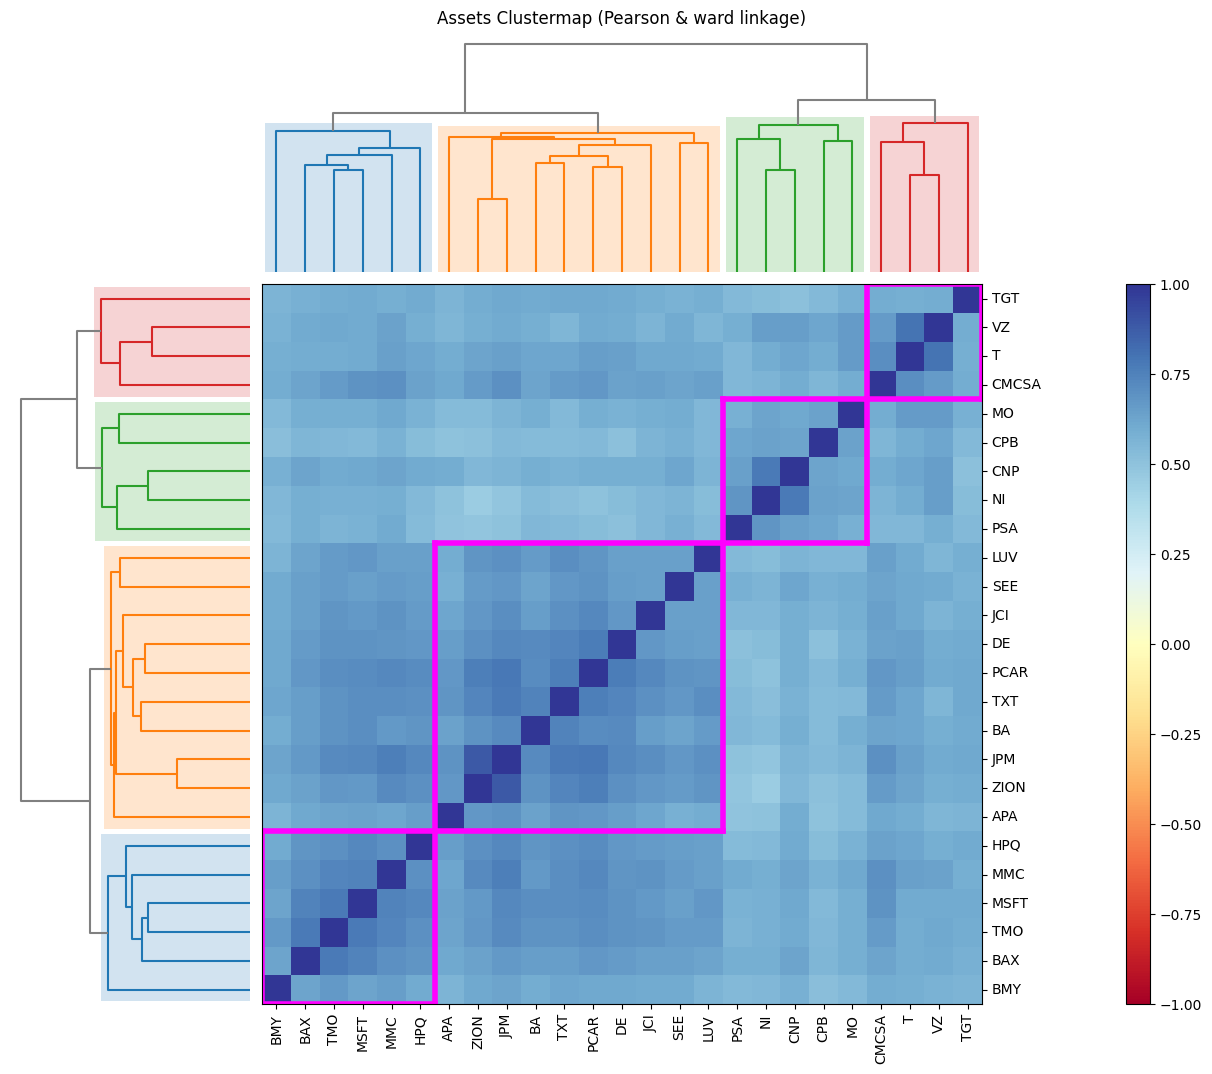

In [3]:
import riskfolio as rp

# Plotting Assets Clusters

ax = rp.plot_clusters(returns=Y,
                      codependence='pearson',
                      linkage='ward',
                      k=None,
                      max_k=10,
                      leaf_order=True,
                      dendrogram=True,
                      #linecolor='tab:purple',
                      ax=None)

## 2. Estimating NCO Portfolio

이것은 López de Prado(2019)가 제안한 원래 모델입니다. Riskfolio-Lib는 이 모델을 13개의 위험 측정치와 네 가지 목표 함수("리스크 최소화", "유틸리티 함수 최대화", "수익/리스크 비율 최대화", "동일 리스크 기여")로 확장했습니다.

### 자세한 설명

**원래 모델 (Original Model)**:
- López de Prado(2019)는 Hierarchical Risk Parity (HRP) 포트폴리오 최적화 기법을 제안했습니다. HRP는 자산 간의 상관관계를 기반으로 계층적 구조를 구성하고, 이를 통해 리스크를 균등하게 분산시키는 방법입니다.
- 이 모델은 계층적 클러스터링을 사용하여 자산을 그룹화하고, 그룹 내 및 그룹 간의 리스크를 관리합니다.

**Riskfolio-Lib의 확장 (Riskfolio-Lib Expansion)**:
- Riskfolio-Lib는 López de Prado의 원래 모델을 기반으로 13개의 다양한 위험 측정치를 포함하도록 확장했습니다.
- 또한 네 가지 주요 목표 함수를 지원합니다:
  1. **리스크 최소화 (Minimize Risk)**: 포트폴리오의 리스크를 최소화하는 것을 목표로 합니다.
  2. **유틸리티 함수 최대화 (Maximize Utility Function)**: 투자자의 위험 회피 성향을 반영하여 포트폴리오의 유틸리티를 최대화합니다.
  3. **수익/리스크 비율 최대화 (Maximize Return/Risk Ratio)**: 샤프 비율과 같은 수익/리스크 비율을 최대화합니다.
  4. **동일 리스크 기여 (Equal Risk Contribution)**: 모든 자산이 포트폴리오 리스크에 동일하게 기여하도록 가중치를 설정합니다.

### 예제 코드 (확장된 HRP 모델 사용)

아래는 Riskfolio-Lib를 사용하여 확장된 HRP 모델을 구현하는 예제 코드입니다.

```python
import numpy as np
import pandas as pd
import riskfolio as rp

# 예시 데이터 생성
np.random.seed(42)
Y = np.random.randn(100, 10)  # 100개의 샘플과 10개의 자산
asset_names = [f'Asset {i}' for i in range(1, 11)]
returns = pd.DataFrame(Y, columns=asset_names)

# 포트폴리오 객체 생성
port = rp.Portfolio(returns=returns)

# 기대 수익률과 공분산 행렬 계산
method_mu = 'hist'
method_cov = 'hist'
port.assets_stats(method_mu=method_mu, method_cov=method_cov)

# HRP 포트폴리오 최적화
model = 'HRP'
rm = 'MV'  # 사용할 위험 측정치 (예: 평균-분산)
obj = 'Sharpe'  # 목표 함수 (예: 샤프 비율 최대화)
hist = True  # 역사적 시나리오 사용
rf = 0  # 무위험 이자율
l = 0  # 위험 회피 계수 (유틸리티 함수에서만 사용)

# 최적 포트폴리오 계산
w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

# 결과 출력
print("Optimal weights:\n", w.T)
```

### 코드 설명
1. **데이터 생성**: 예시 데이터를 생성하고 자산 이름을 설정합니다.
2. **포트폴리오 객체 생성**: `Portfolio` 객체를 생성하고 자산의 기대 수익률과 공분산 행렬을 계산합니다.
3. **HRP 포트폴리오 최적화**: HRP 모델을 사용하여 포트폴리오를 최적화합니다. 이 예제에서는 평균-분산(MV)을 위험 측정치로 사용하고, 샤프 비율을 최대화하는 것을 목표로 합니다.
4. **결과 출력**: 최적화된 포트폴리오 가중치를 출력합니다.

### 위험 측정치 예시
Riskfolio-Lib에서 지원하는 13개의 위험 측정치에는 다음이 포함될 수 있습니다:
1. 평균-분산 (MV: Mean-Variance)
2. 조건부 가치-위험 (CVaR: Conditional Value at Risk)
3. 최대 낙폭 (MDD: Maximum Drawdown)
4. 분산 (Variance)
5. 표준편차 (Standard Deviation)
6. 반편차 (Semi-Deviation)
7. MAD (Mean Absolute Deviation)
8. Gini's Mean Difference
9. LPM (Lower Partial Moment)
10. UPM (Upper Partial Moment)
11. Tail Gini's Mean Difference
12. Tail Mean Absolute Deviation
13. Tail Lower Partial Moment
14. Tail Upper Partial Moment
15. Regret
16. Relent

### 요약
López de Prado(2019)가 제안한 원래 HRP 모델은 자산 간의 상관관계를 활용하여 리스크를 균등하게 분산시키는 포트폴리오 최적화 방법입니다. Riskfolio-Lib는 이 모델을 확장하여 13개의 위험 측정치와 네 가지 목표 함수를 추가로 지원합니다. 이를 통해 투자자들은 다양한 리스크 관리 전략을 활용하여 포트폴리오를 최적화할 수 있습니다.

### 2.1 Calculating the NCO portfolio

비볼록 최적화(Non-Convex Optimization, NCO)는 목적 함수나 제약 조건이 볼록하지 않은 최적화 문제를 다루는 분야입니다. 비볼록 최적화 문제는 다중 극값(local extremum)을 가질 수 있어 전역 최적해(global optimum)를 찾기가 매우 어려울 수 있습니다. 이러한 문제는 다양한 분야에서 발생하며, 특히 금융, 기계 학습, 공학 설계 등에서 중요하게 다뤄집니다.

### 비볼록 최적화의 특징

1. **비볼록 함수**:
   - **정의**: 함수 \( f \)가 볼록(convex)이려면, 임의의 두 점 \( x \)와 \( y \)에 대해 다음이 성립해야 합니다:
     \[
     f(\lambda x + (1-\lambda) y) \leq \lambda f(x) + (1-\lambda) f(y) \quad \forall \lambda \in [0,1]
     \]
   - 비볼록 함수는 위 조건을 만족하지 않으며, 다중 극값을 가질 수 있습니다.
   
2. **복잡성**:
   - 비볼록 최적화 문제는 NP-난해(NP-hard) 문제로 분류될 수 있습니다. 이는 최적해를 찾는 것이 매우 어려울 수 있음을 의미합니다.

3. **다양한 해법**:
   - **전역 최적화 기법**: 예를 들어, 유전자 알고리즘, 심플렉스법, 심층 강화 학습 등을 사용할 수 있습니다.
   - **근사 해법**: 국소 탐색, 힐 클라이밍, 시뮬레이티드 어닐링 등이 있습니다.
   - **휴리스틱 및 메타휴리스틱 기법**: 이 기법들은 주어진 문제에 대한 효율적인 해를 제공하기 위해 사용됩니다.

### 금융 분야에서의 비볼록 최적화

비볼록 최적화는 금융 분야에서 특히 중요합니다. 포트폴리오 최적화 문제는 종종 비볼록 특성을 가집니다. 예를 들어, 자산의 상관관계, 제한된 자본, 거래 비용 등 다양한 요소들이 포트폴리오 최적화 문제를 비볼록으로 만듭니다.

### Non-Convex Optimization (NCO) 예제

위의 코드에서 NCO 모델을 사용하여 포트폴리오를 최적화하는 예제를 보았습니다. 이 예제를 통해 NCO를 사용하는 방법을 다시 한 번 설명드리겠습니다.

#### 예제 코드

```python
import numpy as np
import pandas as pd
import riskfolio as rp

# 예시 데이터 생성
np.random.seed(42)
Y = np.random.randn(100, 10)  # 100개의 샘플과 10개의 자산
asset_names = [f'Asset {i}' for i in range(1, 11)]
returns = pd.DataFrame(Y, columns=asset_names)

# 포트폴리오 객체 생성
port = rp.HCPortfolio(returns=returns)

# 기대 수익률과 공분산 행렬 계산
method_mu = 'hist'
method_cov = 'hist'
port.assets_stats(method_mu=method_mu, method_cov=method_cov)

# NCO 포트폴리오 최적화
model = 'NCO'
codependence = 'pearson'
method_cov = 'hist'
obj = "MinRisk"
rm = 'MV'
rf = 0
l = 2
linkage = 'ward'
max_k = 10
leaf_order = True

# 최적 포트폴리오 계산
w = port.optimization(model=model,
                      codependence=codependence,
                      method_cov=method_cov,
                      obj=obj,
                      rm=rm,
                      rf=rf,
                      l=l,
                      linkage=linkage,
                      max_k=max_k,
                      leaf_order=leaf_order)

# 결과 출력
print("Optimal weights:\n", w.T)
```

### 코드 설명

1. **포트폴리오 객체 생성**: `rp.HCPortfolio` 클래스를 사용하여 포트폴리오 객체를 생성합니다.
2. **기대 수익률 및 공분산 행렬 계산**: `assets_stats` 메서드를 사용하여 기대 수익률과 공분산 행렬을 계산합니다.
3. **최적화 매개변수 설정**: 모델을 `NCO`로 설정하고, 여러 가지 매개변수를 지정합니다.
4. **최적 포트폴리오 계산**: `optimization` 메서드를 사용하여 최적의 포트폴리오 가중치를 계산합니다.
5. **결과 출력**: 최적화된 포트폴리오 가중치를 출력합니다.

### NCO 모델의 장점

1. **유연성**: NCO는 다양한 제약 조건과 목표 함수를 처리할 수 있습니다.
2. **효율성**: 적절한 알고리즘을 사용하면 큰 문제에서도 비교적 빠르게 근사해를 찾을 수 있습니다.
3. **확장성**: 여러 위험 측정치와 목표 함수를 결합하여 다양한 포트폴리오 최적화 문제에 적용할 수 있습니다.

### 결론

비볼록 최적화는 복잡하고 도전적인 문제지만, 적절한 방법과 도구를 사용하면 효과적으로 해결할 수 있습니다. 금융 분야에서 비볼록 최적화는 포트폴리오 최적화와 리스크 관리에 중요한 역할을 하며, 다양한 기법과 알고리즘을 통해 최적해를 찾아낼 수 있습니다.

In [5]:
# Building the portfolio object
port = rp.HCPortfolio(returns=Y)

# Estimate optimal portfolio:

model='NCO' # Could be HRP, HERC or NCO
codependence = 'pearson' # Correlation matrix used to group assets in clusters
method_cov = 'hist' # Covariance estimation technique
obj = "MinRisk" # Posible values are "MinRisk", "Utility", "Sharpe" and "ERC"
rm = 'MV' # Risk measure used, this time will be variance
rf = 0 # Risk free rate
l = 2 # Risk aversion factor, only usefull with "Utility" objective
linkage = 'ward' # Linkage method used to build clusters
max_k = 10 # Max number of clusters used in two difference gap statistic
leaf_order = True # Consider optimal order of leafs in dendrogram

w = port.optimization(model=model,
                      codependence=codependence,
                      method_cov=method_cov,
                      obj=obj,
                      rm=rm,
                      rf=rf,
                      l=l,
                      linkage=linkage,
                      max_k=max_k,
                      leaf_order=leaf_order)

display(w.T)

,APA,BA,BAX,BMY,CMCSA,CNP,CPB,DE,HPQ,JCI,...,NI,PCAR,PSA,SEE,T,TGT,TMO,TXT,VZ,ZION
weights,0.0000%,1.1729%,5.1828%,2.8237%,5.0010%,10.9745%,3.7075%,0.7664%,0.3470%,2.4531%,...,7.0044%,0.1994%,12.0257%,2.2921%,4.8851%,3.0259%,1.1105%,0.0000%,8.6247%,0.0000%


이 코드는 `riskfolio` 라이브러리를 사용하여 포트폴리오 최적화를 수행하는 예제입니다. 이 예제에서는 Hierarchical Clustering Portfolio (HCPortfolio) 객체를 생성하고, 여러 가지 매개변수를 설정하여 최적의 포트폴리오 가중치를 계산합니다. 각 단계별로 코드를 자세히 설명하겠습니다.

### 포트폴리오 객체 생성

```python
port = rp.HCPortfolio(returns=Y)
```
- `rp.HCPortfolio`: `riskfolio` 라이브러리의 HCPortfolio 클래스를 사용하여 포트폴리오 객체를 생성합니다.
- `returns=Y`: 자산의 역사적 수익률 데이터 `Y`를 사용합니다.

### 최적화 매개변수 설정

```python
model='NCO'  # 사용할 모델: HRP, HERC 또는 NCO 중 하나
codependence = 'pearson'  # 자산을 클러스터로 그룹화하는 데 사용되는 상관 행렬
method_cov = 'hist'  # 공분산 추정 기법: 역사적 데이터를 사용
obj = "MinRisk"  # 목표 함수: "MinRisk", "Utility", "Sharpe", "ERC" 중 하나
rm = 'MV'  # 사용된 위험 측정치: 여기서는 분산을 사용
rf = 0  # 무위험 이자율
l = 2  # 위험 회피 계수: "Utility" 목표 함수에서만 유용
linkage = 'ward'  # 클러스터를 구성하는 데 사용되는 연결 방법
max_k = 10  # 두 차이 간격 통계를 사용하여 사용되는 최대 클러스터 수
leaf_order = True  # 덴드로그램에서 리프의 최적 순서를 고려할지 여부
```

- `model='NCO'`: 사용할 모델을 지정합니다. 여기서는 Non-Convex Optimization (NCO)을 사용합니다. 다른 옵션으로는 HRP (Hierarchical Risk Parity)와 HERC (Hierarchical Equal Risk Contribution)가 있습니다.
- `codependence='pearson'`: 상관 행렬을 Pearson 상관계수를 사용하여 계산합니다.
- `method_cov='hist'`: 공분산 행렬을 역사적 데이터를 기반으로 추정합니다.
- `obj='MinRisk'`: 목표 함수로 최소 리스크를 선택합니다. 다른 가능한 값으로는 "Utility", "Sharpe", "ERC"가 있습니다.
- `rm='MV'`: 위험 측정치로 분산을 사용합니다.
- `rf=0`: 무위험 이자율을 0으로 설정합니다.
- `l=2`: 위험 회피 계수를 2로 설정합니다. 이 값은 "Utility" 목표 함수에서만 유용합니다.
- `linkage='ward'`: 클러스터를 구성하는 데 사용되는 연결 방법을 Ward 방법으로 설정합니다.
- `max_k=10`: 두 차이 간격 통계를 사용하여 사용되는 최대 클러스터 수를 10으로 설정합니다.
- `leaf_order=True`: 덴드로그램에서 리프의 최적 순서를 고려합니다.

### 포트폴리오 최적화

```python
w = port.optimization(model=model,
                      codependence=codependence,
                      method_cov=method_cov,
                      obj=obj,
                      rm=rm,
                      rf=rf,
                      l=l,
                      linkage=linkage,
                      max_k=max_k,
                      leaf_order=leaf_order)
```
- `port.optimization`: 설정된 매개변수를 사용하여 포트폴리오 최적화를 수행합니다.
- 최적화된 포트폴리오 가중치 벡터 `w`를 반환합니다.

### 최적화 결과 출력

```python
display(w.T)
```
- `display(w.T)`: 최적화된 포트폴리오 가중치 벡터 `w`를 전치(transpose)하여 보기 좋게 출력합니다.

### 전체 요약
이 코드는 `riskfolio` 라이브러리를 사용하여 포트폴리오 최적화를 수행하는 예제입니다. HCPortfolio 객체를 생성하고 여러 매개변수를 설정한 후, 포트폴리오 최적화를 수행하여 최적의 가중치를 계산합니다. 최종적으로, 최적화된 포트폴리오 가중치를 출력합니다. 

이 방법을 통해 투자자는 다양한 리스크 측정치와 목표 함수를 사용하여 포트폴리오를 최적화할 수 있습니다.

### 2.2 Plotting portfolio composition

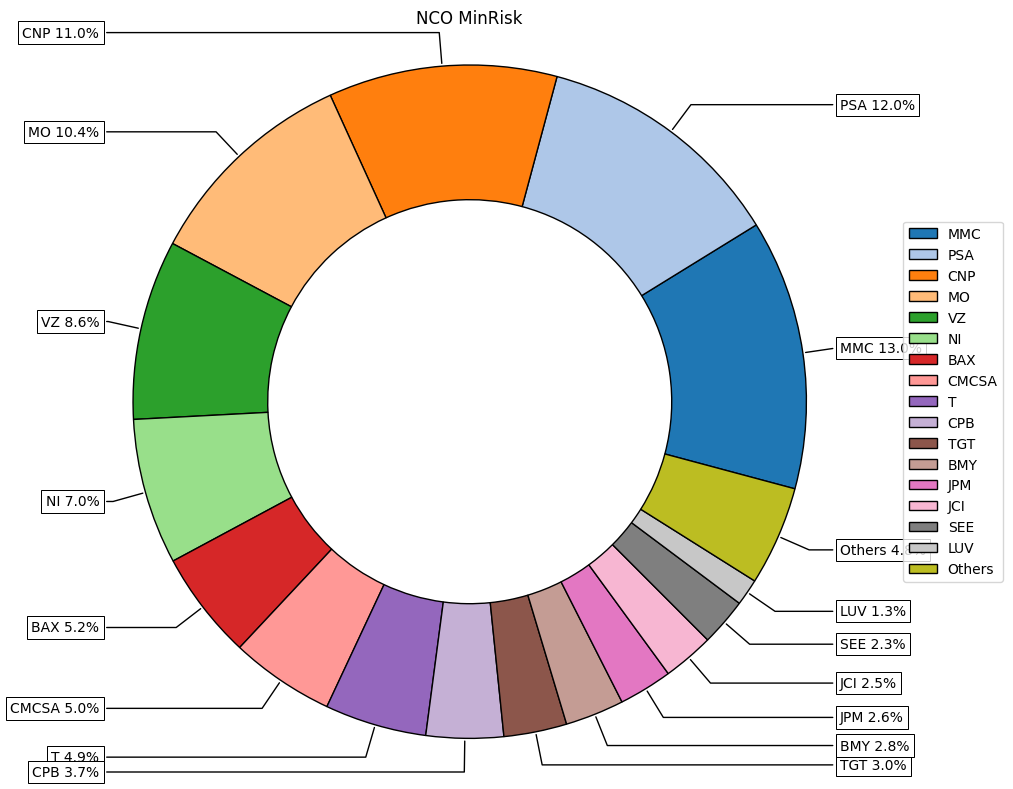

In [6]:
# Plotting the composition of the portfolio

ax = rp.plot_pie(w=w,
                 title='NCO MinRisk',
                 others=0.05,
                 nrow=25,
                 cmap="tab20",
                 height=8,
                 width=10,
                 ax=None)

### 2.3 Plotting Risk Contribution

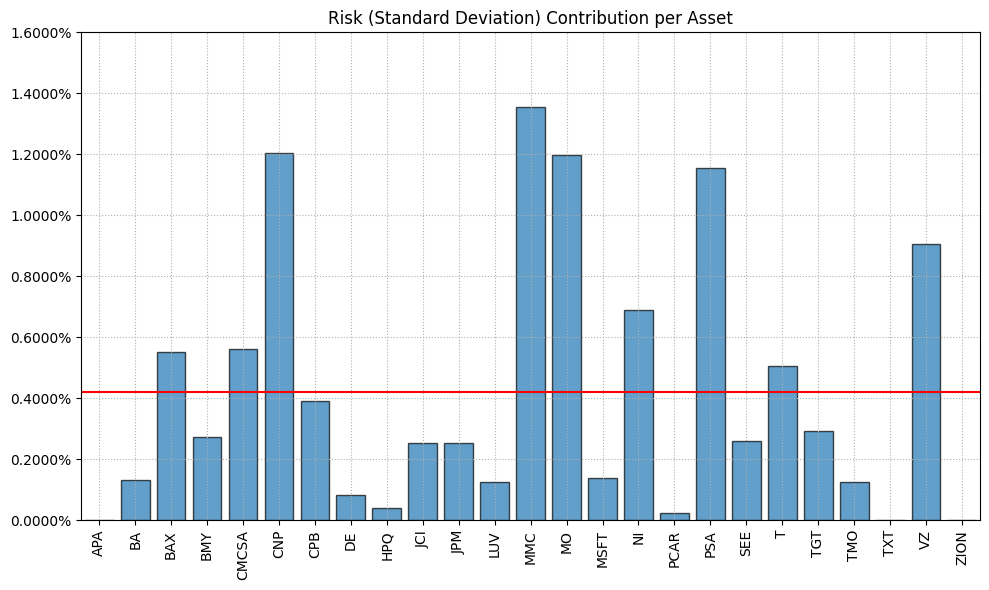

In [7]:
# Plotting the risk contribution per asset

mu = Y.mean()
cov = Y.cov() # Covariance matrix
returns = Y # Returns of the assets

ax = rp.plot_risk_con(w=w,
                      cov=cov,
                      returns=returns,
                      rm=rm,
                      rf=0,
                      alpha=0.05,
                      color="tab:blue",
                      height=6,
                      width=10,
                      t_factor=252,
                      ax=None)

### 2.4 Calculate Optimal NCO Portfolios for Several Risk Measures

In [8]:
# Risk Measures available:
#
# 'MV': Variance.
# 'MAD': Mean Absolute Deviation.
# 'MSV': Semi Standard Deviation.
# 'FLPM': First Lower Partial Moment (Omega Ratio).
# 'SLPM': Second Lower Partial Moment (Sortino Ratio).
# 'CVaR': Conditional Value at Risk.
# 'EVaR': Entropic Value at Risk.
# 'WR': Worst Realization (Minimax)
# 'MDD': Maximum Drawdown of uncompounded cumulative returns (Calmar Ratio).
# 'ADD': Average Drawdown of uncompounded cumulative returns.
# 'CDaR': Conditional Drawdown at Risk of uncompounded cumulative returns.
# 'EDaR': Entropic Drawdown at Risk of uncompounded cumulative returns.
# 'UCI': Ulcer Index of uncompounded cumulative returns.

rms = ['MV', 'MAD', 'MSV', 'FLPM', 'SLPM',
       'CVaR', 'EVaR', 'WR', 'MDD', 'ADD',
       'CDaR', 'EDaR', 'UCI']

w_s = pd.DataFrame([])

for i in rms:
    w = port.optimization(model=model,
                          codependence=codependence,
                          method_cov=method_cov,
                          obj=obj,
                          rm=i,
                          rf=rf,
                          linkage=linkage,
                          max_k=max_k,
                          leaf_order=leaf_order)

    w_s = pd.concat([w_s, w], axis=1)
    
w_s.columns = rms

In [9]:
w_s.style.format("{:.2%}").background_gradient(cmap='YlGn')

,MV,MAD,MSV,FLPM,SLPM,CVaR,EVaR,WR,MDD,ADD,CDaR,EDaR,UCI
APA,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
BA,1.17%,1.61%,0.67%,1.58%,0.64%,0.14%,0.00%,0.00%,4.28%,2.17%,0.86%,2.72%,0.00%
BAX,5.18%,4.84%,4.73%,6.09%,5.19%,4.79%,8.19%,0.00%,0.00%,10.86%,6.00%,3.13%,8.26%
BMY,2.82%,3.26%,2.52%,2.79%,2.38%,1.81%,6.25%,0.00%,0.00%,0.60%,0.00%,0.87%,0.41%
CMCSA,5.00%,5.21%,4.54%,5.40%,4.72%,2.94%,0.49%,0.00%,0.71%,3.36%,0.00%,0.00%,0.11%
CNP,10.97%,9.44%,11.69%,9.96%,11.93%,15.62%,13.49%,0.00%,29.30%,9.69%,18.59%,24.27%,17.15%
CPB,3.71%,3.20%,5.47%,2.39%,5.16%,6.55%,6.27%,2.83%,0.00%,0.00%,0.03%,0.00%,0.00%
DE,0.77%,1.02%,0.59%,1.03%,0.61%,0.10%,0.00%,0.00%,12.76%,0.62%,1.16%,7.24%,0.00%
HPQ,0.35%,0.58%,0.00%,0.68%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
JCI,2.45%,2.77%,1.89%,2.26%,1.54%,0.28%,0.00%,0.00%,0.00%,1.45%,0.23%,0.00%,0.00%


<Axes: >

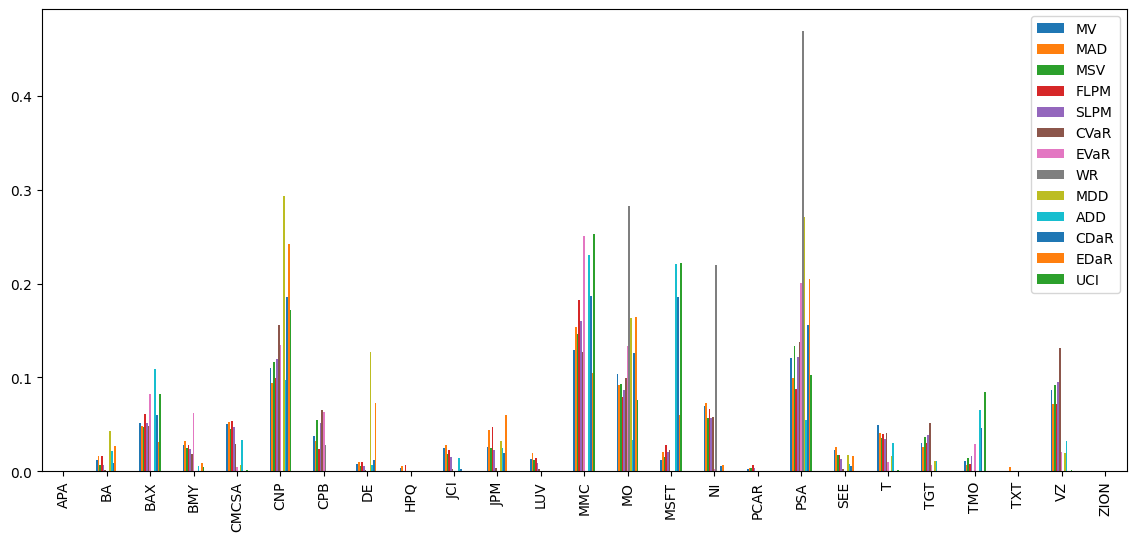

In [10]:
import matplotlib.pyplot as plt

# Plotting a comparison of assets weights for each portfolio

fig = plt.gcf()
fig.set_figwidth(14)
fig.set_figheight(6)
ax = fig.subplots(nrows=1, ncols=1)

w_s.plot.bar(ax=ax)